# Walmart Dataset Solution - MLP

This notebook and others can be downloaded from [here](https://github.com/shment/shment.github.io).

Walmart [dataset](https://www.kaggle.com/datasets/yasserh/walmart-dataset) consist of the weekly sales in different Walmart stores from 2010-02-05 to 2012-11-01. Our goal here is to predict the sales for a given week.
In this notebook we will see how to:
1. load data stored in a csv file to pandas dataframe
2. convert categorical to numeric features using scikit learn
3. handle date feature 
4. scale numeric features to be suitable for MLP
5. learn MLP model using pytorch to predict the sales
6. save and load the model and other auxiliaries for inference on new samples 

First we will import the libraries we will use:

In [52]:
import numpy as np
import torch 
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import joblib
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

Next we load the data to pandas dataframe and separate the target variable(weekly sales) from the rest.

In [53]:
df_x = pd.read_csv('/kaggle/input/walmart-dataset/Walmart.csv')
df_y = df_x['Weekly_Sales']
df_x = df_x.drop(columns=['Weekly_Sales'])

Here we check for problems in the data such as nan values and wrong data type.

In [54]:
pd.concat([df_x.nunique(axis=0), df_x.isna().sum(axis=0), df_x.dtypes], axis=1).rename(columns={0: 'uniques', 1:'na', 2:'type'})

,uniques,na,type
Store,45,0,int64
Date,143,0,object
Holiday_Flag,2,0,int64
Temperature,3528,0,float64
Fuel_Price,892,0,float64
CPI,2145,0,float64
Unemployment,349,0,float64


The data don't have nan values, but the *Store* and *Holiday_Flag* features need to be categorical - there is no sense in "store 1 is bigger then store 0". In addition, the *Date* feature has order - 2010-02-05 is before 2010-02-06, so we need to convert it to numerical feature in a way that will that into account. In addition, the month and the year has valuable information that we want to keep (November sales are probably higher). Simple way for doing that is to create 3 new features - *day*, *month* and *year*. If we needed to predict daily sales, since there is likely a correlation between the week day and the sales, we should have added another feature for the weekday (Sunday, Monday,...). However, since we are predicting weekly sales, it has no meaning for our problem.

In [55]:
df_x['Store'] = df_x['Store'].astype(object)
df_x['Holiday_Flag'] = df_x['Holiday_Flag'].astype(object)

df_x['Date'] = pd.to_datetime(df_x['Date'])
df_x['day'] = df_x['Date'].dt.day
df_x['month'] = df_x['Date'].dt.month
df_x['year'] = df_x['Date'].dt.year

df_x = df_x.drop(columns=['Date'])

Split the data to train and test sets.


In [56]:
#train test split
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.1, random_state=1)

MLP requires all features to be in the same scale. Here we scale them to have mean=0 and std=1.

In [57]:
numeric_features = list(x_train.loc[:, x_train.dtypes != object])
numeric_encoder = StandardScaler()
numeric_encoder.fit(x_train.loc[:, numeric_features])
x_train.loc[:, numeric_features] = numeric_encoder.transform(x_train.loc[:, numeric_features])
x_test.loc[:, numeric_features] = numeric_encoder.transform(x_test.loc[:, numeric_features])

In order to convert the categorical features to numeric ones, we use one hot encoding.

In [58]:
categorical_features = list(x_train.loc[:, x_train.dtypes == object])
cat_encoder = OneHotEncoder()
cat_encoder.fit(x_train.loc[:, categorical_features])

transformed = cat_encoder.transform(x_train.loc[:, categorical_features].to_numpy())
ohe = pd.DataFrame(transformed.toarray(), columns=cat_encoder.get_feature_names_out())
x_train = x_train.reset_index()
x_train = pd.concat([x_train, ohe], axis=1)
x_train = x_train.drop(columns=categorical_features)

transformed = cat_encoder.transform(x_test.loc[:, categorical_features].to_numpy())
ohe = pd.DataFrame(transformed.toarray(), columns=cat_encoder.get_feature_names_out())
x_test = x_test.reset_index()
x_test = pd.concat([x_test, ohe], axis=1)
x_test = x_test.drop(columns=categorical_features)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  "X does not have valid feature names, but"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  "X does not have valid feature names, but"


Next we define our model. Input for the model is a list of the dimensions.

In [59]:
class MLP(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.dims = dims
        self.layers = nn.ModuleList()
        for i in range(len(dims) - 1):
            self.layers.append(nn.Linear(dims[i], dims[i + 1]))

        self.activation = nn.ReLU()

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = self.activation(x)
        
        if self.dims[-1] == 1:
            return x.view(-1)
        else:
            return x

and the dataset

In [60]:
class MyDataset(data.Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x.to_numpy()
        self.y = y.to_numpy()

    def __getitem__(self, index):
        sample = self.x[index]
        target = self.y[index]
        return torch.from_numpy(sample).float(), torch.from_numpy(np.array(target)).float()

    def __len__(self):
        return self.y.shape[0]

Choose hyperparameters

In [61]:
loss_func = nn.L1Loss()
batch_size = 512
learning_rate = 0.01
num_epochs = 2000
dims = [55, 512, 512, 1]
decay_every = 500
decay = 0.5
model_dims = {'dims': dims}

Now we can set every thing up:
1. create a model and move it to gpu
2. create an optimizer - we use learning rate decay here
3. create dataloader

In [62]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MLP(dims)
model = model.to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, decay_every, gamma=decay)
train_dataset = MyDataset(x_train, y_train)
test_dataset = MyDataset(x_test, y_test)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=55, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
  (activation): ReLU()
)


and start the training loop.

In [ ]:
for epoch in range(1, num_epochs + 1):
    print('epoch:', epoch)
    model.train()
    for samples, targets in train_loader:
        samples = samples.to(device)
        targets = targets.to(device)
        preds = model(samples)
        loss = loss_func(preds, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        
    scheduler.step()
    model.eval() 
    with torch.no_grad():
        for mode, loader in zip(['train', 'test'], [train_loader, test_loader]):
            epoch_loss, rel_abs_error, num_samples = 0, 0, 0
            for samples, targets in loader:
                samples = samples.to(device)
                targets = targets.to(device)
                preds = model(samples)
                loss = loss_func(preds, targets)
                epoch_loss += loss.item() * targets.shape[0] 
                rel_abs_error += torch.abs((targets - preds) / targets).sum() 
                num_samples += targets.shape[0]

            epoch_loss = epoch_loss / num_samples
            rel_abs_error = rel_abs_error / num_samples
            print(mode, '- mae:', f'{epoch_loss:.2}', 'mape:', f'{rel_abs_error:.2}')

The model is ready, we can save it and the one hot encoder for future use.


In [64]:
torch.save(model.state_dict(), 'model.ckpt')
joblib.dump(model_dims, 'model_dims.joblib')
joblib.dump(numeric_encoder, 'numeric_encoder.joblib')
joblib.dump(cat_encoder, 'cat_encoder.joblib')
joblib.dump(numeric_features, 'numeric_features.joblib')
joblib.dump(categorical_features, 'categorical_features.joblib')

['categorical_features.joblib']

Here is how to use the model on new data.
Numerical and categorical encoding already done on *x_test* so we skip this part

In [65]:
model_dims = joblib.load('model_dims.joblib')
model = MLP(model_dims['dims'])
model.load_state_dict(torch.load('model.ckpt'))
numeric_encoder = joblib.load('numeric_encoder.joblib')
cat_encoder = joblib.load('cat_encoder.joblib')
numeric_features = joblib.load('numeric_features.joblib')
categorical_features = joblib.load('categorical_features.joblib')

_, df_inference, _, _ = train_test_split(df_x, df_y, test_size=0.1, random_state=1)

'''
x_test.loc[:, numeric_features] = numeric_encoder.transform(x_test.loc[:, numeric_features])
transformed = cat_encoder.transform(x_test.loc[:, categorical_features].to_numpy())
ohe = pd.DataFrame(transformed.toarray(), columns=cat_encoder.get_feature_names_out())
x_test = x_test.reset_index()
x_test = pd.concat([x_test, ohe], axis=1)
x_test = x_test.drop(columns=categorical_features)
'''

'\nx_test.loc[:, numeric_features] = numeric_encoder.transform(x_test.loc[:, numeric_features])\ntransformed = cat_encoder.transform(x_test.loc[:, categorical_features].to_numpy())\nohe = pd.DataFrame(transformed.toarray(), columns=cat_encoder.get_feature_names_out())\nx_test = x_test.reset_index()\nx_test = pd.concat([x_test, ohe], axis=1)\nx_test = x_test.drop(columns=categorical_features)\n'

Now we can use our model to predict weekly sales of the new data. 
We need to move the model and data to the same device, and performe the necessary manipulation as done in the dataloader.
For debuging, we can save our predictions in a csv file.

In [66]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
test_pred = model(torch.from_numpy(x_test.to_numpy()).float().to(device))
test_pred = test_pred.detach().cpu().numpy()
mae = mean_absolute_error(test_pred, y_test)
mape = mean_absolute_percentage_error(test_pred, y_test)
print('MAE:', mae)
print('MAPE:', mape)
df_inference['pred'] = test_pred
df_inference['mae'] = np.abs(test_pred - y_test)
df_inference['mape'] = mae / y_test
df_inference.to_csv('df_inference.csv', index=False)

MAE: 70074.20480007764
MAPE: 0.06552580466433054


The following figure shows that prediction of weekly sales for some stores are harder.

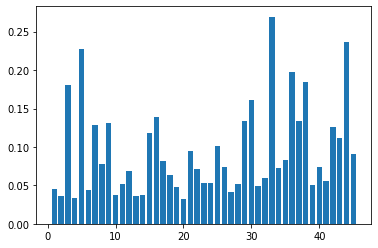

In [67]:
df_groupby_store = df_inference.groupby(['Store']).mean()
fig, ax = plt.subplots()
ax.bar(df_groupby_store.index, df_groupby_store['mape'])
fig.show()